<a href="https://colab.research.google.com/github/r0cketr1kky/COVID-19_X-Ray/blob/master/Integrated_ScoreCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tf-explain

     |████████████████████████████████| 51kB 3.4MB/s 


In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
!pip install saliency

In [0]:
 class InvalidState(ValueError):
    def __init__(self, message, *args):
        self.message = message # without this you may get DeprecationWarning
        super(InvalidState, self).__init__(message, *args)

In [0]:
import numpy as np
from skimage.transform import resize


def resize_activations(enhanced_model_output, input_shape):
    resized_activations = []
    for i in range(enhanced_model_output.shape[-1]):
        # resizing every activation map to original input image spatial dimensions
        resized_activations.append(resize(enhanced_model_output[..., i], input_shape, preserve_range=True))
    return np.array(resized_activations)


def normalize_activations(activation_maps):
    flattened = activation_maps.reshape((activation_maps.shape[0], -1))
    # min/max for each map
    max_a = np.max(flattened, axis=1)
    min_a = np.min(flattened, axis=1)

    # make norm = 1 where diff is zero (instead of adding/removing small epsilon)
    diffs = np.where(max_a > min_a, max_a - min_a, 1)
    return (activation_maps - min_a.reshape((-1, 1, 1))) / diffs.reshape((-1, 1, 1))

In [0]:
import tensorflow as tf
from tensorflow.keras import Model
import numpy as np

class ScoreCAM:
    def __init__(self, model_input, last_conv_output, softmax_output, input_shape, cam_batch_size=None):
        """
        Prepares class activation mappings
        :param model_input: input layer of CNN, normally takes batch of images as an input. Currently batch must be limited to a single image
        :param last_conv_output: last convolutional layer. The last conv layer contains the most complete information about image.
        :param softmax_output: flat softmax (or similar) layer describing the class certainty
        :param input_shape: Expecting a batch of a single input sample 1 x M X N X ...; it is assumed that 2D image of M x N dimensions is served as an input, which can be multiplied with a 2D-mask.
        :param cam_batch_size: Optional, defaults to None, which will result in inference of batches of size 32.
        """
        self.model_input = model_input
        self.last_conv_output = last_conv_output
        self.softmax_output = softmax_output
        self.last_conv_model = Model(inputs=model_input, outputs=last_conv_output)
        self.softmax_model = Model(inputs=model_input, outputs=softmax_output)
        self.input_shape = input_shape
        self.cam_batch_size = cam_batch_size

        self.normalized_maps = None
        self.classes_activation_scale = None

    def prepare_cam(self, input):
        output_conv = self.last_conv_model.predict(input)
        # Only first image from convolutions will be used
        resized = resize_activations(output_conv[0], self.input_shape)
        # filter_size x input_shape[0] x input_shape[1] - resized to original input dimensions
        normalized_maps = normalize_activations(resized)

        # repeat input
        repeat_input = np.tile(input, (normalized_maps.shape[0], 1, 1, 1))
        expanded_activation_maps = np.expand_dims(normalized_maps, axis=3)
        masked_images = np.multiply(repeat_input, expanded_activation_maps)
        # input: filter_size x input_shape[0] x input_shape[1] -> Output filter_size x Classes_Count
        self.classes_activation_scale = self.softmax_model.predict(masked_images,
                                                                   batch_size=self.cam_batch_size)
        self.normalized_maps = normalized_maps

        print(self.classes_activation_scale.shape)

        print(self.normalized_maps.shape)

    def get_class_heatmap(self, class_id):
        if self.normalized_maps is None or self.classes_activation_scale is None:
            raise InvalidState('Call prepare_cam before accessing get_class_heatmap, '
                               'activations must be prepared via prepare_cam')
        final_weights = self.classes_activation_scale[:, class_id]
        final_maps = np.multiply(self.normalized_maps, final_weights.reshape((-1, 1, 1)))
        # ReLU
        print(final_maps.shape)
        final_maps_max = np.max(final_maps, axis=0)
        print(final_maps_max.shape)
        final_class_activation_map = np.where(final_maps_max > 0, final_maps_max, 0)
        #print(final_class_activation_map.shape)
        return final_class_activation_map

In [0]:
import tensorflow.keras, os 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, AvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [6]:
train_datagen = ImageDataGenerator(rescale=1/255,
  rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	horizontal_flip=True,
	fill_mode="nearest")
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        '/gdrive/My Drive/dataset',  
        target_size=(400,400),
        batch_size=32,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        '/gdrive/My Drive/Validation',  
        target_size=(400,400), 
        batch_size=16,
        class_mode='categorical')


Found 44 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [0]:
model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(400,400,3), activation="relu"))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(32, (3,3), activation="relu"))
model.add(Dropout(0.5))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Dropout(0.5))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Dropout(0.5))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Dropout(0.5))
model.add(MaxPool2D((2,2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [8]:
'''
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(AvgPool2D((4,4)))
model.add(Flatten())
model.add(Dense(4096,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4096 ,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))


'''
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 398, 398, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 199, 199, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 197, 197, 32)      4640      
_________________________________________________________________
dropout (Dropout)            (None, 197, 197, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 96, 64)        0

In [0]:
input_shape = (400, 400)
conv_layers = model.layers[-7].output
softmax_output = model.layers[-1].output

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(
      train_generator,
      steps_per_epoch=44//4,  
      epochs=10,
      verbose=1,
      batch_size=4,
      validation_steps=6//4,
      validation_data = validation_generator)

Epoch 1/10
11/11 [==============================] - 13s 1s/step - loss: 1.4746 - accuracy: 0.4563 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 2/10
11/11 [==============================] - 12s 1s/step - loss: 0.6824 - accuracy: 0.5216 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
11/11 [==============================] - 12s 1s/step - loss: 0.6668 - accuracy: 0.5794 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 4/10
11/11 [==============================] - 12s 1s/step - loss: 0.5297 - accuracy: 0.7586 - val_loss: 0.6982 - val_accuracy: 0.5000
Epoch 5/10
11/11 [==============================] - 11s 1s/step - loss: 0.5286 - accuracy: 0.8095 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 6/10
11/11 [==============================] - 11s 1s/step - loss: 0.2950 - accuracy: 0.8750 - val_loss: 0.6553 - val_accuracy: 0.6667
Epoch 7/10
11/11 [==============================] - 11s 1s/step - loss: 0.2459 - accuracy: 0.8968 - val_loss: 0.6411 - val_accuracy: 0.8333
Epoch 8/10
11/11 [==

In [31]:
import keras
from keras_applications.vgg16 import preprocess_input
from keras_preprocessing.image import load_img, img_to_array

source_img = load_img('/gdrive/My Drive/covid-chestxray-dataset/images/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day3.jpg', target_size=input_shape)
img = img_to_array(source_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img, backend=keras.backend)
img.shape

(1, 400, 400, 3)

In [32]:
scoreCAM = ScoreCAM(model_input=model.input, last_conv_output=conv_layers, softmax_output=softmax_output, input_shape=input_shape)
scoreCAM.prepare_cam(img)

(64, 2)
(64, 400, 400)


In [0]:
import math

def grid_display(array, num_rows=None, num_columns=None):
    """
    Display a list of images as a grid.
    Args:
        array (numpy.ndarray): 4D Tensor (batch_size, height, width, channels)
    Returns:
        numpy.ndarray: 3D Tensor as concatenation of input images on a grid
    """
    if num_rows is not None and num_columns is not None:
        total_grid_size = num_rows * num_columns
        if total_grid_size < len(array):
            warnings.warn(
                Warning(
                    "Given values for num_rows and num_columns doesn't allow to display "
                    "all images. Values have been overrided to respect at least num_columns"
                )
            )
            num_rows = math.ceil(len(array) / num_columns)
    elif num_rows is not None:
        num_columns = math.ceil(len(array) / num_rows)
    elif num_columns is not None:
        num_rows = math.ceil(len(array) / num_columns)
    else:
        num_rows = math.ceil(math.sqrt(len(array)))
        num_columns = math.ceil(math.sqrt(len(array)))

    number_of_missing_elements = num_columns * num_rows - len(array)
    # We fill the array with np.zeros elements to obtain a perfect square
    array = np.append(
        array,
        np.zeros((number_of_missing_elements, *array[0].shape)).astype(array.dtype),
        axis=0,
    )

    grid = np.concatenate(
        [
            np.concatenate(
                array[index * num_columns : (index + 1) * num_columns], axis=1
            )
            for index in range(num_rows)
        ],
        axis=0,
    )

    return grid

def transform_to_normalized_grayscale(tensor):
    """
    Transform tensor over RGB axis to grayscale.
    Args:
        tensor (tf.Tensor): 4D-Tensor with shape (batch_size, H, W, 3)
    Returns:
        tf.Tensor: 4D-Tensor of grayscale tensor, with shape (batch_size, H, W, 1)
    """
    grayscale_tensor = tf.reduce_mean(tensor, axis=-1)

    return grayscale_tensor

In [0]:
class IntegratedGradients:

    """
    Perform Integrated Gradients algorithm for a given input
    Paper: [Axiomatic Attribution for Deep Networks](https://arxiv.org/pdf/1703.01365.pdf)
    """

    def explain(self, validation_data, model, class_index, n_steps=10):
        """
        Compute Integrated Gradients for a specific class index
        Args:
            validation_data (Tuple[np.ndarray, Optional[np.ndarray]]): Validation data
                to perform the method on. Tuple containing (x, y).
            model (tf.keras.Model): tf.keras model to inspect
            class_index (int): Index of targeted class
            n_steps (int): Number of steps in the path
        Returns:
            np.ndarray: Grid of all the integrated gradients
        """
        images = validation_data

        interpolated_images = IntegratedGradients.generate_interpolations(
            images, n_steps
        )

        integrated_gradients = IntegratedGradients.get_integrated_gradients(
            interpolated_images, model, class_index, n_steps
        )

        gray = transform_to_normalized_grayscale(tf.abs(integrated_gradients)).numpy()

        
        return gray

    @staticmethod
    @tf.function
    def get_integrated_gradients(interpolated_images, model, class_index, n_steps):
        """
        Perform backpropagation to compute integrated gradients.
        Args:
            interpolated_images (numpy.ndarray): 4D-Tensor of shape (N * n_steps, H, W, 3)
            model (tf.keras.Model): tf.keras model to inspect
            class_index (int): Index of targeted class
            n_steps (int): Number of steps in the path
        Returns:
            tf.Tensor: 4D-Tensor of shape (N, H, W, 3) with integrated gradients
        """
        with tf.GradientTape() as tape:
            inputs = tf.cast(interpolated_images, tf.float32)
            tape.watch(inputs)
            predictions = model(inputs)
            loss = predictions[:, class_index]

        grads = tape.gradient(loss, inputs)
        grads_per_image = tf.reshape(grads, (-1, n_steps, *grads.shape[1:]))

        integrated_gradients = tf.reduce_mean(grads_per_image, axis=1)

        return integrated_gradients

    @staticmethod
    def generate_interpolations(images, n_steps):
        """
        Generate interpolation paths for batch of images.
        Args:
            images (numpy.ndarray): 4D-Tensor of images with shape (N, H, W, 3)
            n_steps (int): Number of steps in the path
        Returns:
            numpy.ndarray: Interpolation paths for each image with shape (N * n_steps, H, W, 3)
        """
        baseline = np.zeros(images.shape[1:])

        return np.concatenate(
            [
                IntegratedGradients.generate_linear_path(baseline, image, n_steps)
                for image in images
            ]
        )

    @staticmethod
    def generate_linear_path(baseline, target, n_steps):
        """
        Generate the interpolation path between the baseline image and the target image.
        Args:
            baseline (numpy.ndarray): Reference image
            target (numpy.ndarray): Target image
            n_steps (int): Number of steps in the path
        Returns:
            List(np.ndarray): List of images for each step
        """
        return [
            baseline + (target - baseline) * index / (n_steps - 1)
            for index in range(n_steps)
        ]

    def save(self, grid, output_dir, output_name):
        """
        Save the output to a specific dir.
        Args:
            grid (numpy.ndarray): Grid of all the heatmaps
            output_dir (str): Output directory path
            output_name (str): Output name
        """
        save_grayscale(grid, output_dir, output_name)

In [0]:
#from tf_explain.core.integrated_gradients import *
x = IntegratedGradients().explain(img, model, 0)

In [36]:
x.shape

(1, 400, 400)

In [37]:
ans = np.matmul(x, scoreCAM.get_class_heatmap(0))
ans = np.reshape(ans, [400, 400])
ans.shape

(64, 400, 400)
(400, 400)


(400, 400)

In [0]:
import matplotlib.pyplot as plt


def draw_original_and_heatmap(ans, class_id):
    heatmap = ans
    f = plt.figure(figsize=(8,8))
    left = f.add_subplot(131)
    left.set_title("Original image")
    left.axis('off')
    left.imshow(source_img)
    
    right = f.add_subplot(132)    
    right.set_title("Heatmap for class {}".format(class_id))
    right.axis('off')
    right.imshow(heatmap, cmap='plasma')
    
    merged = f.add_subplot(133)    
    merged.set_title("Overlay for class {}".format(class_id))
    merged.axis('off')
    merged.imshow(source_img, alpha=0.5)
    merged.imshow(heatmap, cmap='plasma', alpha=0.5)

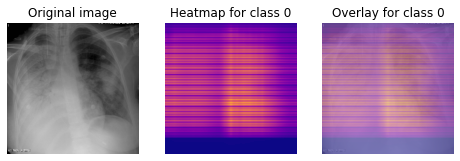

In [39]:
draw_original_and_heatmap(ans, 0)

In [43]:
x = IntegratedGradients().explain(img, model, 1)
ans1 = np.dot(x, scoreCAM.get_class_heatmap(1))
ans1 = np.reshape(ans1, [400, 400])
ans1.shape

(64, 400, 400)
(400, 400)


(400, 400)

In [44]:
'''import matplotlib.pyplot as plt


def draw_original_and_heatmap1(ans, class_id):
    heatmap = ans1
    f = plt.figure(figsize=(8,8))
    left = f.add_subplot(131)
    left.set_title("Original image")
    left.axis('off')
    left.imshow(source_img)
    
    right = f.add_subplot(132)    
    right.set_title("Heatmap for class {}".format(class_id))
    right.axis('off')
    right.imshow(heatmap, cmap='plasma')
    
    merged = f.add_subplot(133)    
    merged.set_title("Overlay for class {}".format(class_id))
    merged.axis('off')
    merged.imshow(source_img, alpha=0.5)
    merged.imshow(heatmap, cmap='plasma', alpha=0.45)
'''

'import matplotlib.pyplot as plt\n\n\ndef draw_original_and_heatmap1(ans, class_id):\n    heatmap = ans1\n    f = plt.figure(figsize=(8,8))\n    left = f.add_subplot(131)\n    left.set_title("Original image")\n    left.axis(\'off\')\n    left.imshow(source_img)\n    \n    right = f.add_subplot(132)    \n    right.set_title("Heatmap for class {}".format(class_id))\n    right.axis(\'off\')\n    right.imshow(heatmap, cmap=\'plasma\')\n    \n    merged = f.add_subplot(133)    \n    merged.set_title("Overlay for class {}".format(class_id))\n    merged.axis(\'off\')\n    merged.imshow(source_img, alpha=0.5)\n    merged.imshow(heatmap, cmap=\'plasma\', alpha=0.45)\n'

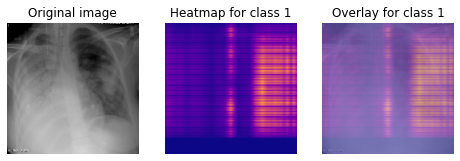

In [45]:
draw_original_and_heatmap(ans1, 1)

In [0]:
source_img = load_img('/gdrive/My Drive/covid-chestxray-dataset/images/1-s2.0-S1684118220300682-main.pdf-002-a1.png', target_size=input_shape)
img = img_to_array(source_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img, backend=keras.backend)

In [47]:
scoreCAM = ScoreCAM(model_input=model.input, last_conv_output=conv_layers, softmax_output=softmax_output, input_shape=input_shape)
scoreCAM.prepare_cam(img)

(64, 2)
(64, 400, 400)


(64, 400, 400)
(400, 400)


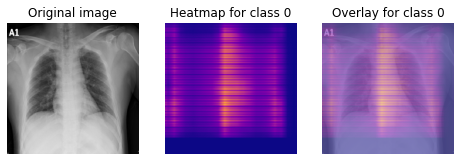

In [48]:
x = IntegratedGradients().explain(img, model, 0)
ans = np.matmul(x, scoreCAM.get_class_heatmap(0))
ans = np.reshape(ans, [400, 400])
ans.shape
draw_original_and_heatmap(ans, 0)

(64, 400, 400)
(400, 400)


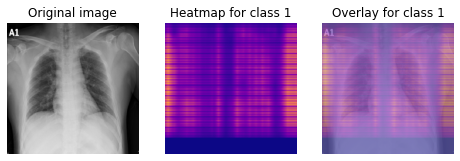

In [49]:
x = IntegratedGradients().explain(img, model, 1)
ans = np.matmul(x, scoreCAM.get_class_heatmap(1))
ans = np.reshape(ans, [400, 400])
ans.shape
draw_original_and_heatmap(ans, 1)

(64, 2)
(64, 400, 400)
(64, 400, 400)
(400, 400)


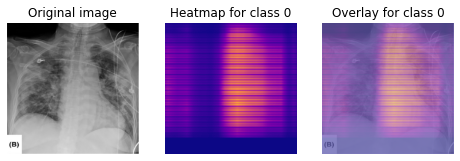

In [51]:
source_img = load_img('/gdrive/My Drive/covid-chestxray-dataset/images/all14238-fig-0001-m-b.jpg', target_size=input_shape)
img = img_to_array(source_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img, backend=keras.backend)

scoreCAM = ScoreCAM(model_input=model.input, last_conv_output=conv_layers, softmax_output=softmax_output, input_shape=input_shape)
scoreCAM.prepare_cam(img)

x = IntegratedGradients().explain(img, model, 0)
ans = np.matmul(x, scoreCAM.get_class_heatmap(0))
ans = np.reshape(ans, [400, 400])
ans.shape

draw_original_and_heatmap(ans, 0)

(64, 2)
(64, 400, 400)
(64, 400, 400)
(400, 400)


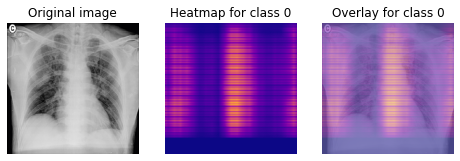

In [52]:
source_img = load_img('/gdrive/My Drive/covid-chestxray-dataset/images/jkms-35-e79-g001-l-c.jpg', target_size=input_shape)
img = img_to_array(source_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img, backend=keras.backend)

scoreCAM = ScoreCAM(model_input=model.input, last_conv_output=conv_layers, softmax_output=softmax_output, input_shape=input_shape)
scoreCAM.prepare_cam(img)

x = IntegratedGradients().explain(img, model, 0)
ans = np.matmul(x, scoreCAM.get_class_heatmap(0))
ans = np.reshape(ans, [400, 400])
ans.shape

draw_original_and_heatmap(ans, 0)

In [0]:
#NOW LETS CHECK FOR A NORMAL CHEST RAY, THE ABOVE X-RAYS ARE COVID-AFFECTED.

(64, 2)
(64, 400, 400)
(64, 400, 400)
(400, 400)


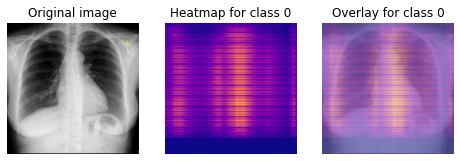

In [53]:
source_img = load_img('/gdrive/My Drive/normal_chestxray.jpeg', target_size=input_shape)
img = img_to_array(source_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img, backend=keras.backend)

scoreCAM = ScoreCAM(model_input=model.input, last_conv_output=conv_layers, softmax_output=softmax_output, input_shape=input_shape)
scoreCAM.prepare_cam(img)

x = IntegratedGradients().explain(img, model, 0)
ans = np.matmul(x, scoreCAM.get_class_heatmap(0))
ans = np.reshape(ans, [400, 400])
ans.shape

draw_original_and_heatmap(ans, 0)

(64, 400, 400)
(400, 400)


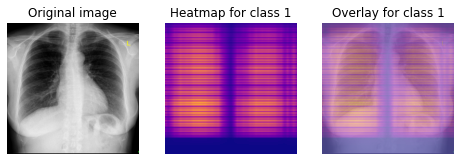

In [55]:
x = IntegratedGradients().explain(img, model, 1)
ans = np.matmul(x, scoreCAM.get_class_heatmap(1))
ans = np.reshape(ans, [400, 400])
ans.shape

draw_original_and_heatmap(ans, 1)

(64, 2)
(64, 400, 400)
(64, 400, 400)
(400, 400)


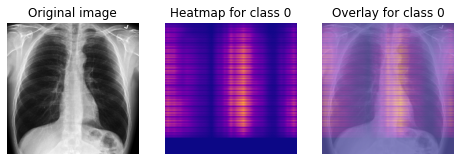

In [56]:
source_img = load_img('/gdrive/My Drive/chestxraynormal.jpg', target_size=input_shape)
img = img_to_array(source_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img, backend=keras.backend)

scoreCAM = ScoreCAM(model_input=model.input, last_conv_output=conv_layers, softmax_output=softmax_output, input_shape=input_shape)
scoreCAM.prepare_cam(img)

x = IntegratedGradients().explain(img, model, 0)
ans = np.matmul(x, scoreCAM.get_class_heatmap(0))
ans = np.reshape(ans, [400, 400])
ans.shape

draw_original_and_heatmap(ans, 0)

(64, 400, 400)
(400, 400)


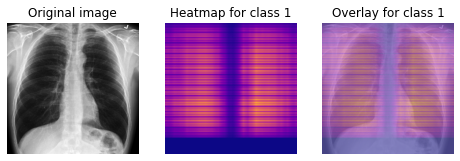

In [57]:
x = IntegratedGradients().explain(img, model, 1)
ans = np.matmul(x, scoreCAM.get_class_heatmap(1))
ans = np.reshape(ans, [400, 400])
ans.shape
draw_original_and_heatmap(ans, 1)

In [0]:
# AS YOU CAN SEE, CLASS 1 IS DOMINANT HERE BECAUSE IT PERTAINS TO NORMAL,
# AND CLASS 0 WHICH IS COVID, IS PRESENT IN SMALL AMOUNTS, WHICH EXPLAINS HOW OUR
# NEURAL NET IS PERFORMING!!!